In [2]:
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.generation import MaxPosteriorSampling
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

from torch.quasirandom import SobolEngine
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from botorch.utils.transforms import unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from src.mixturemodel import MixtureModel
import matplotlib.pyplot as plt

import math
from dataclasses import dataclass

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'botorch.generation'

In [104]:
device = torch.device("cpu")
dtype = torch.double

In [70]:
sim = MixtureModel(concentrations=[1., 0.])
P = 80
T_start, T_end = 200, 451
T_span = np.linspace(T_start, T_end, T_end - T_start + 1)
res = sim.get_density(P, T_span)

Getting too close to iteration limit. Exiting...


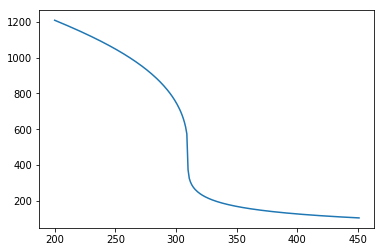

In [71]:
plt.plot(T_span, res)

In [107]:
lb_T, ub_T = 260, 320
lb_P, ub_P = 80, 130

def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to()
    return X_init
    
def central_differences(P, T):
    P, T = unnormalize(P, (lb_P, ub_P)), unnormalize(T, (lb_T, ub_T))
    T_start, T_end = T-1, T+1
    T_span = np.linspace(T_start, T_end, T_end - T_start + 1)
    res = sim.get_density(P, T_span)

    dddT = (res[-1] - res[0]) / 2
    return dddT

def eval_objective(x):
    """This is a helper function we use to unnormalize and evaluate a point"""
    P, T = x
    return central_differences(P, T)

central_differences(1, 1)

-10.440209386658807

In [73]:
# build training set
n_samples = 100
x_train = []
y_train = []

for sample in range(n_samples):
    P, T = np.random.randint(80, 130), np.random.randint(260, 320)
    y = central_differences(P, T)
    x_train.append([P, T])
    y_train.append(y)

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train)[:, None].float()

Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...


In [108]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [103]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim, dtype=dtype, device=device)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

In [105]:
dim = 2
batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

In [ ]:
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)

NUM_RESTARTS = 10 
RAW_SAMPLES = 512 
N_CANDIDATES = min(5000, max(2000, 200 * dim)) 

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_model(mll)
    
        # Create a batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )

    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )